In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, CubicSpline, interp1d
from scipy.optimize import curve_fit
import time
import scipy


from openparticle.hamiltonians.free_hamiltonians import free_boson_Hamiltonian, free_fermion_Hamiltonian
from openparticle.hamiltonians.yukawa_hamiltonians import *
from openparticle.hamiltonians.renormalized_yukawa_hamiltonian import *
from openparticle.utils import *
from openparticle.dlcq import get_sector_basis, pdf, fock_sector_budget
from yukawa_utils import *

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Universal parameters in all plots:
mf = 1
mb = 0.5

### `Plot #1`: Bare $M^2$ vs. $K$

In [253]:
plot_1_g = 1

eigenvalues_boson_loop = []
eigenvalues_fermion_loop = []
eigenvalues_Q2 = []
resolutions_boson_loop = np.arange(1, 9, 1)
resolutions_fermion_loop = np.arange(1/2, 9, 1)
resolutions_Q2 = np.arange(3, 9, 1)

for res in resolutions_boson_loop:

    basis = impose_baryon_number(int(res), momentum_states_partition(res), 0)
    

    
    hamiltonian = yukawa_hamiltonian(
            res=int(res), g=plot_1_g, mf=mf, mb=mb
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_boson_loop.append(min(vals))

for res in resolutions_fermion_loop:

    basis = impose_baryon_number(int(res + 1/2), momentum_states_partition(res), 1)
    hamiltonian = yukawa_hamiltonian(
            res=int(res + 1/2), g=plot_1_g, mf=mf, mb=mb
        )
    tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_fermion_loop.append(min(vals))

for res in resolutions_Q2:

    basis = impose_baryon_number(int(res), momentum_states_partition(res), 2)
    

    hamiltonian = yukawa_hamiltonian(
            res=int(res), g=plot_1_g, mf=mf, mb=mb
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_Q2.append(min(vals))
    


Text(0.5, 1.0, 'Lowest $M^2$ Eigenvalue in Respective Sectors')

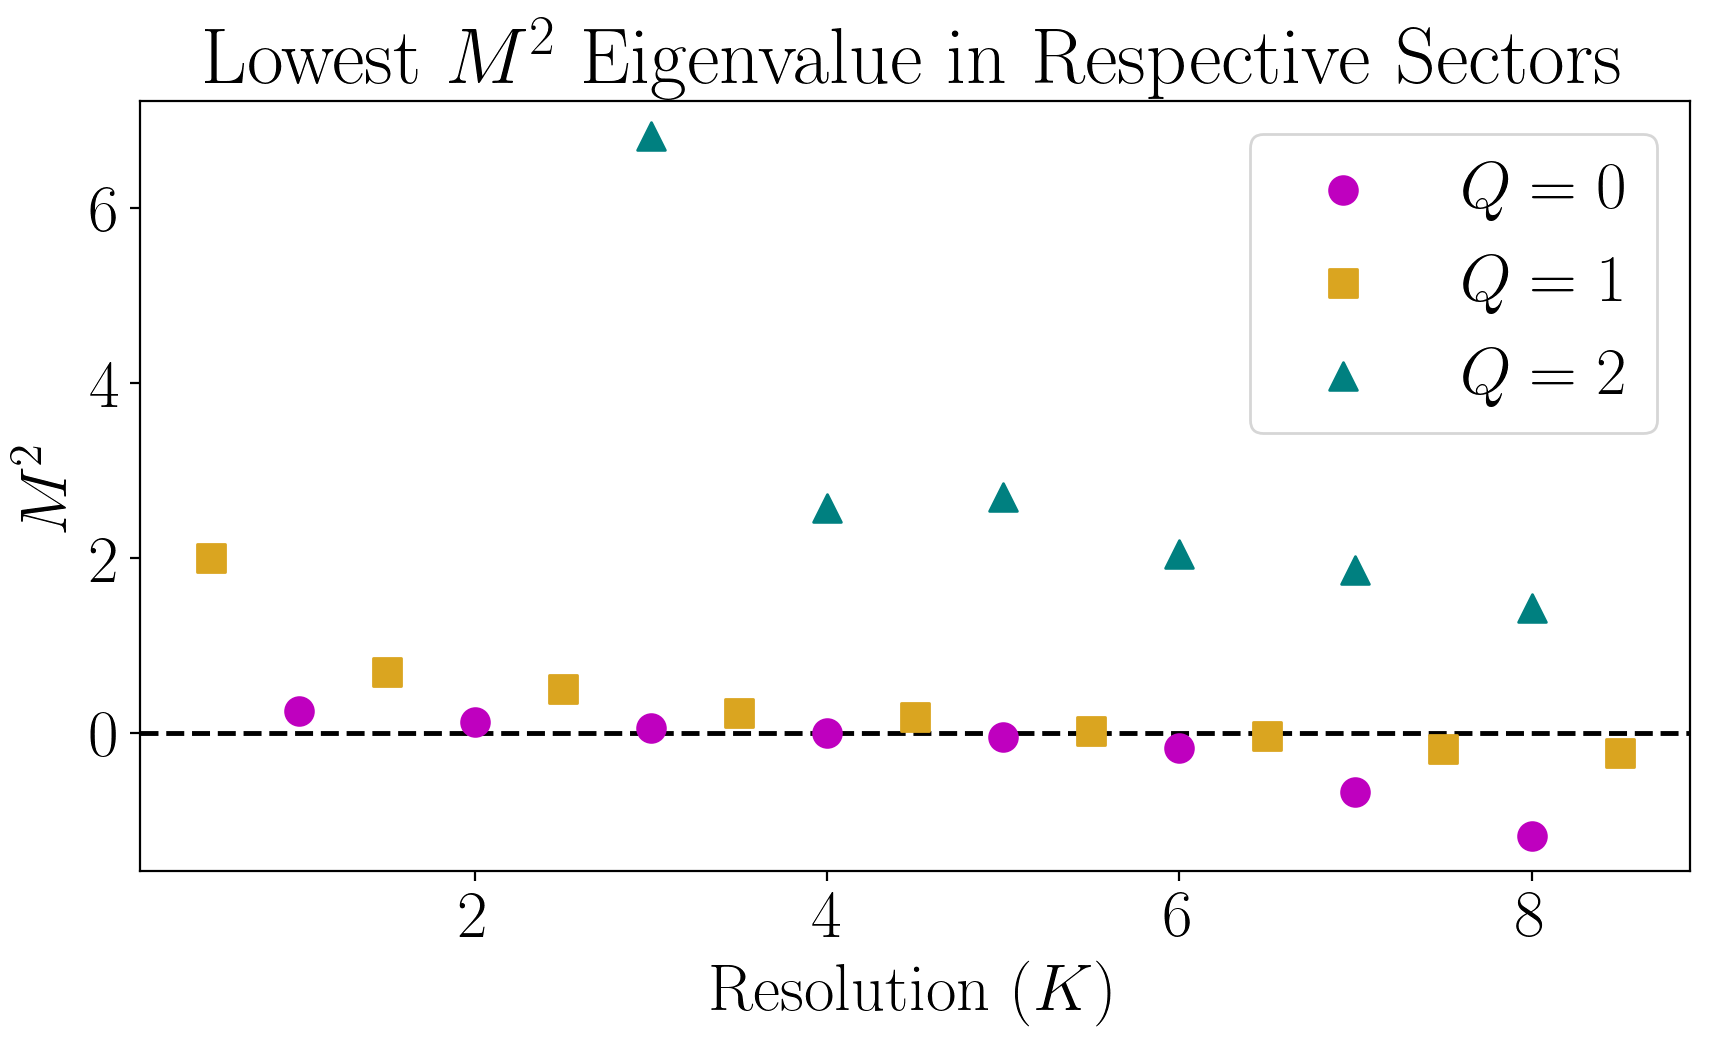

In [274]:
plt.figure(figsize=(10,5), dpi=200)
plt.scatter(resolutions_boson_loop, eigenvalues_boson_loop, color='m', marker='o', s=100, label = r'$Q = 0$')
plt.scatter(resolutions_fermion_loop, eigenvalues_fermion_loop, color='goldenrod', marker='s', s=100, label = r'$Q = 1$')
plt.scatter(resolutions_Q2, eigenvalues_Q2, color=[(0,0.5,0.5)], marker='^', s=100, label = r'$Q = 2$')

plt.axhline(y=0, color='k', linewidth = 1.75, zorder = -1, linestyle = '--')

plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")
plt.legend()
plt.title(r"Lowest $M^2$ Eigenvalue in Respective Sectors")

### `Plot #2:` Yukawa Non-relativistic $E$ vs. $\mu$

In [5]:
plot_2_g = 0.3

N = 200  # Number of grid points
x_max = 20 # Maximum x value (adjust as needed)
x_min = -20
dx = (x_max-x_min)/N
x = np.linspace(x_min, x_max, N+1)

def create_hamiltonian(V):
  c = 1 ** 2 / ( mf * dx ** 2)
  hamiltonian = np.zeros((N+1, N+1))
  for i in range(1, N - 1):
      hamiltonian[i, i] = 2 * c + V[i]
      hamiltonian[i, i + 1] = -c
      hamiltonian[i, i - 1] = -c
  return hamiltonian

bounds = []
mus = np.arange(0.05, 1, 0.005)
for mu in mus:
    V = -plot_2_g**2 / (2 * mu) * np.exp(-mu * np.abs(x))
    H=create_hamiltonian(V)

    # Solve for eigenvalues and eigenvectors and sort
    eigenvalues, eigenvectors = np.linalg.eig(H)
    bounds.append(eigenvalues[eigenvalues < 0])

padded_eigenvalues_plot_2 = np.array(
    [
        np.pad(eig, (0, max(len(eig) for eig in bounds) - len(eig)), constant_values=np.nan)
        for eig in bounds
    ]
)

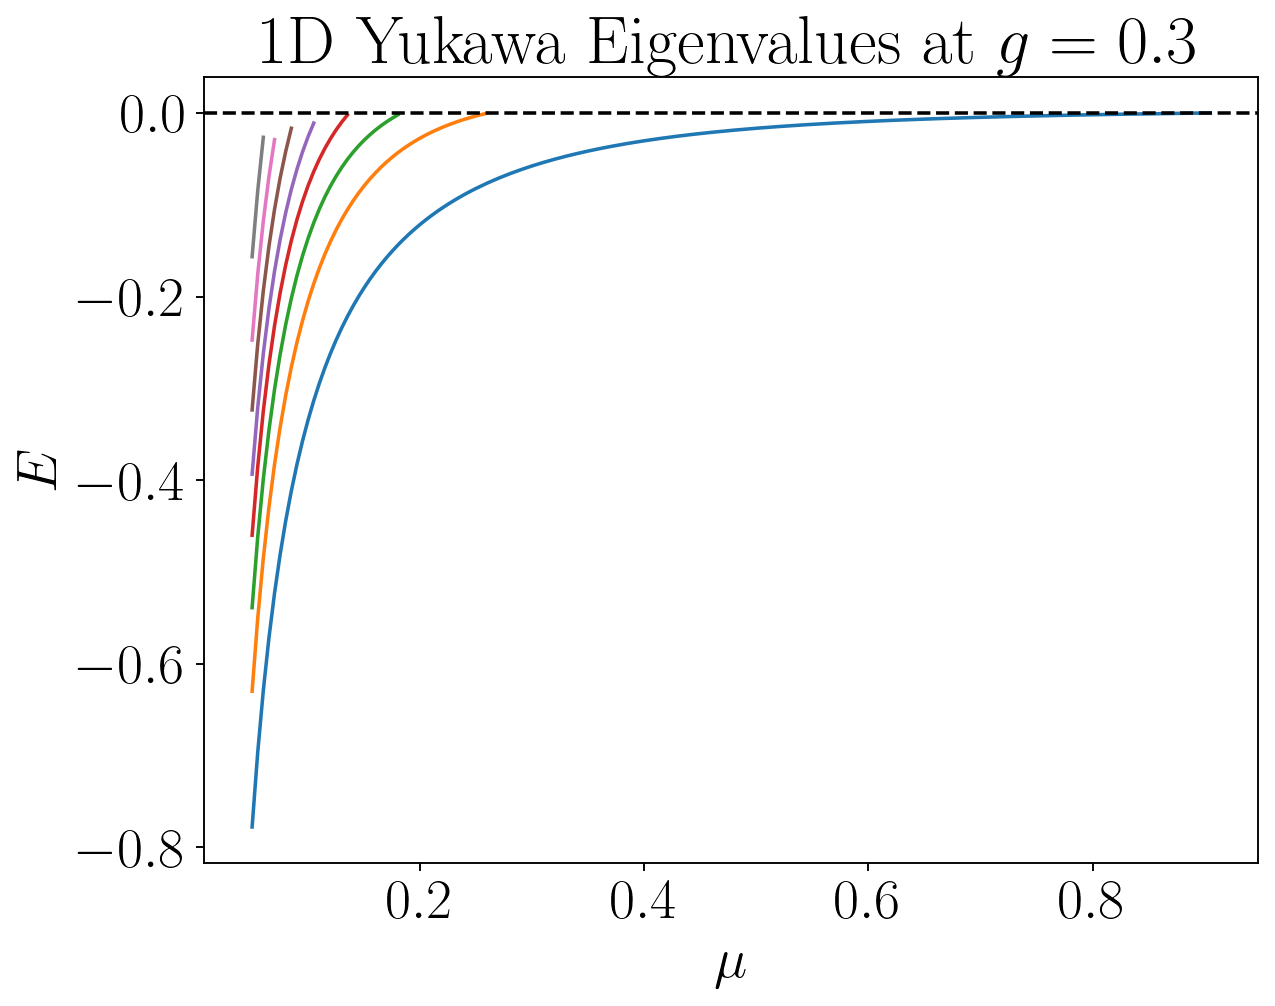

In [6]:
plt.figure(figsize=(8, 6), dpi=170)
plt.plot(mus, padded_eigenvalues_plot_2)
plt.ylabel(f"$E$")
plt.xlabel(f"$\mu$")
plt.title(f"1D Yukawa Eigenvalues at $g = {plot_2_g}$")
plt.axhline(y = 0, linestyle = '--', color = 'k')
# plt.ylim(-1, 0.1)
plt.show()

### `Plot #3`: Renormalized $M^2$ vs. $K$ for sectors $\{|f\rangle, |fb\rangle \}$ and $\{|ff\rangle, |ffb\rangle \}$ at $g \in \{0.3, 1, 3 \}$

In [230]:
plot_3_t = 1e-12

$g = 0.3$

In [231]:
max_K = 20

plot_3_g_1 = 0.3

eigenvalues_f_fb_basis_g03 = []
eigenvalues_ff_ffb_basis_g03 = []

f_fb_resolutions = np.arange(1/2, max_K, 2)
ff_ffb_resolutions = np.arange(2, max_K + 1, 2)

for res in f_fb_resolutions:

    f_fb_basis = (
        get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=plot_3_t, treg=0, g=plot_3_g_1, mf=mf, mb=mb, verbose=False
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, f_fb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_f_fb_basis_g03.append(min(vals))

for res in ff_ffb_resolutions:

    ff_ffb_basis = (
        get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=plot_3_t, treg=0, g=plot_3_g_1, mf=mf, mb=mb, verbose=False
        )
    
    tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_ff_ffb_basis_g03.append(min(vals))

In [232]:
def t(Lambda):
    return 1/(Lambda**4)

def _lambda(t):
    return t**(-1/4)

Text(15, 7, '$\\lambda = 1000.0$')

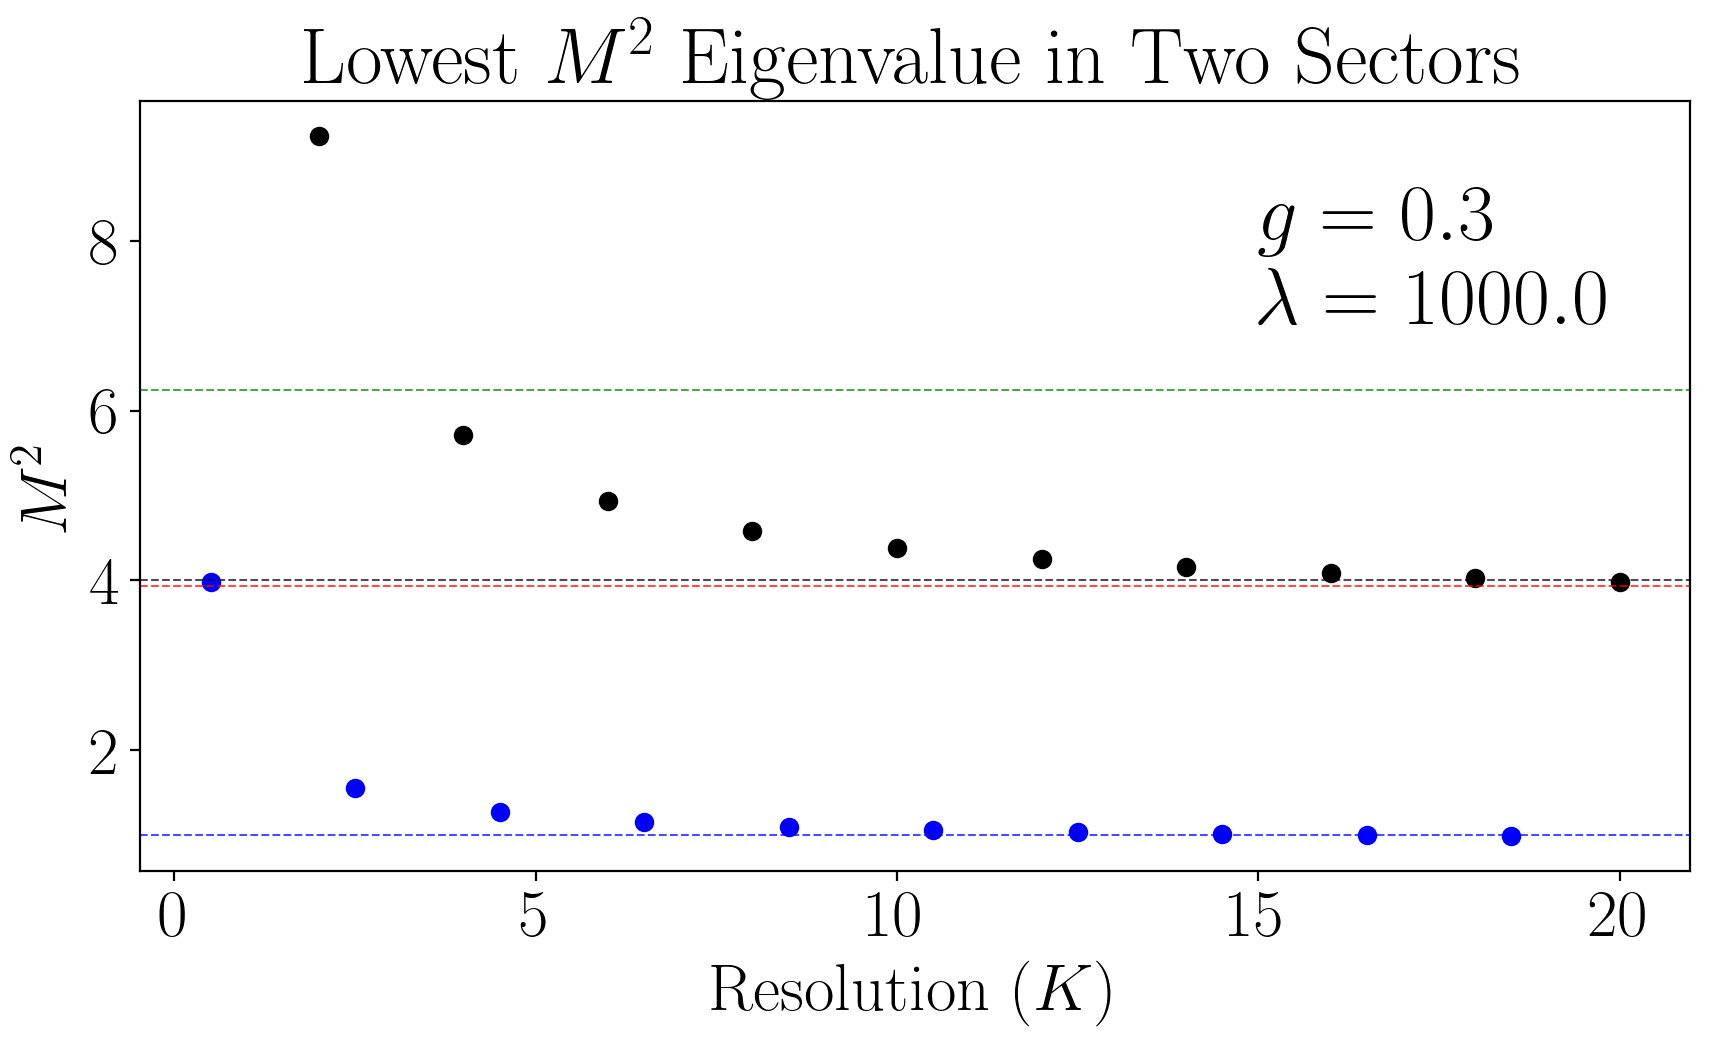

In [235]:
plt.figure(figsize=(10,5), dpi=200)

plt.plot(f_fb_resolutions, eigenvalues_f_fb_basis_g03, 'bo')
plt.plot(ff_ffb_resolutions, eigenvalues_ff_ffb_basis_g03, 'ko')

plt.axhline(y=mf**2, color='b', alpha = 0.7, linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf)**2, color='k', alpha = 0.7,linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf + mb)**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 0.75)
plt.axhline(y=min(nonrelativistic_yukawa(plot_3_g_1, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 0.75)

plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")
# plt.title(f'$g = {plot_3_g_1}$')
plt.title(r"Lowest $M^2$ Eigenvalue in Two Sectors")
plt.text(15, 8, f'$g = {plot_3_g_1}$', fontsize=29)
# plt.text(17, 7, f'$t = {1/(plot_3_t**2)}$', fontsize=29)
plt.text(15, 7, f'$\lambda = {_lambda(plot_3_t)}$', fontsize=29)



In [293]:
def m2_fit(x, a, b, c):
    return a + b/x + c/(x**2)

g03_fit_params = curve_fit(m2_fit, f_fb_resolutions, eigenvalues_f_fb_basis_g03)

Text(0.5, 1.0, 'Lowest $M^2$ Eigenvalue in Two Sectors')

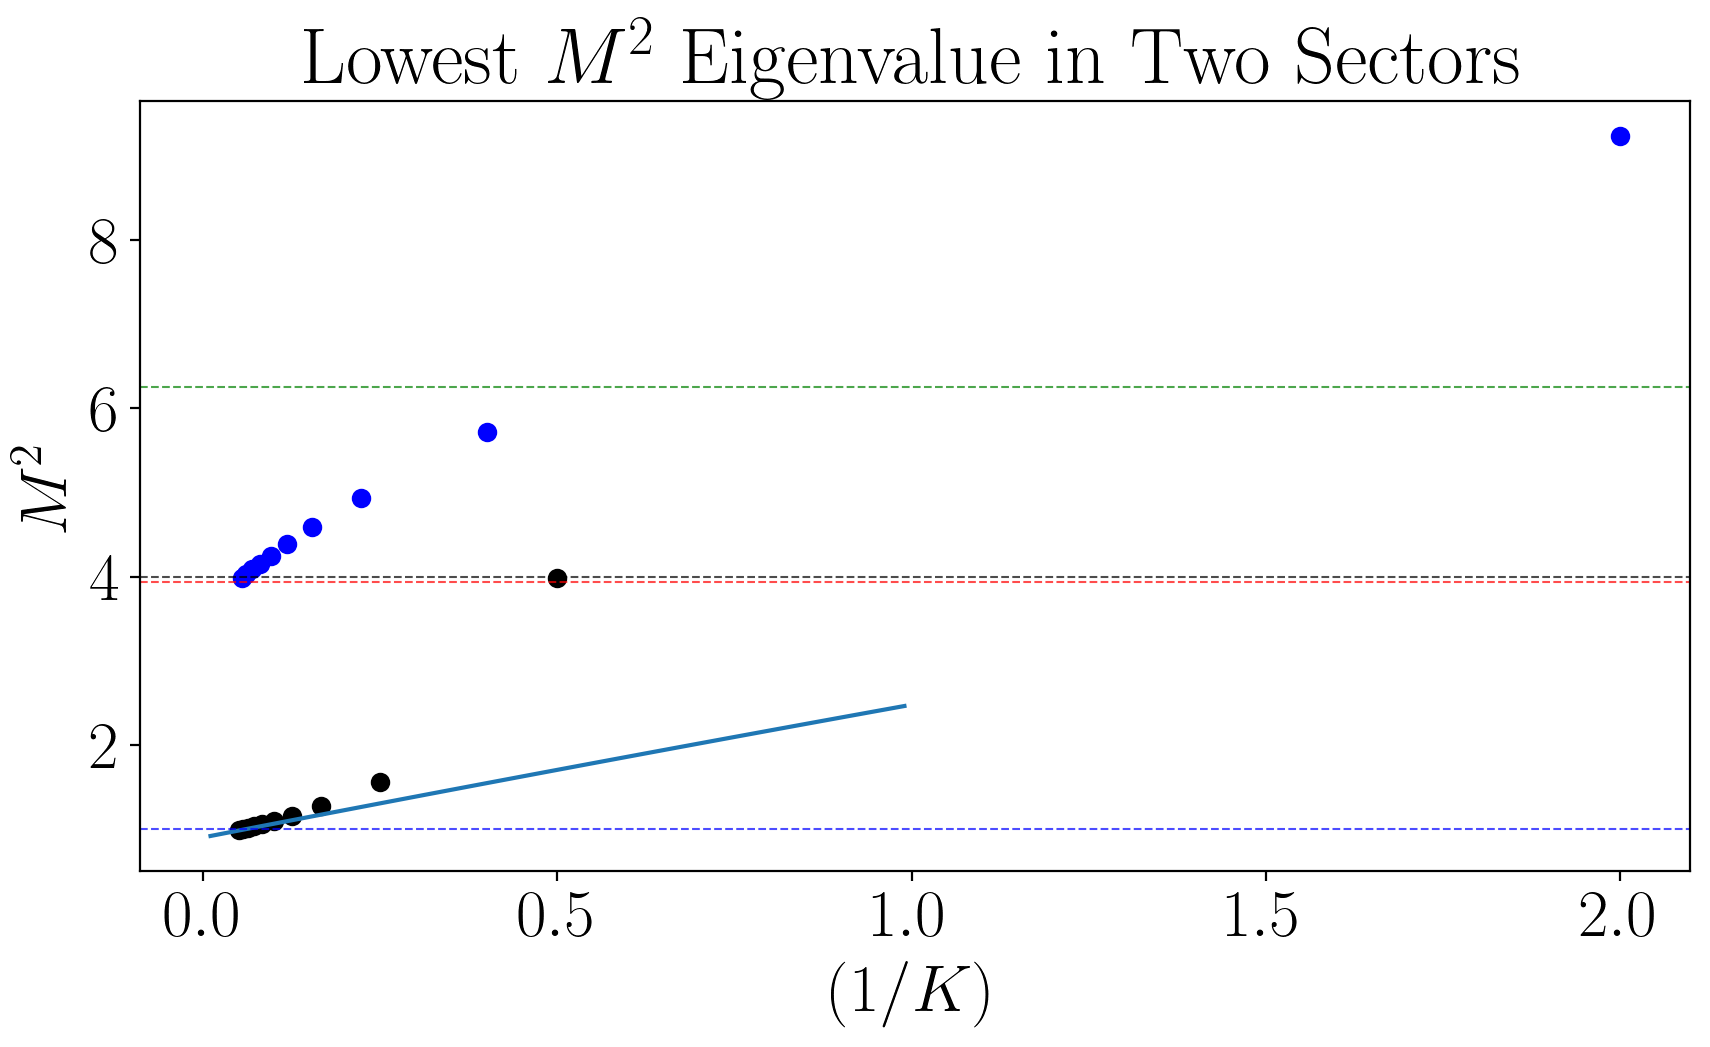

In [287]:
plt.figure(figsize=(10,5), dpi=200)

ks = np.arange(0.01, 1, 0.01)

plt.plot(1/ff_ffb_resolutions, eigenvalues_f_fb_basis_g03, 'ko')
plt.plot(ks, m2_fit(1/ks, *g03_fit_params[0]))
plt.plot(1/f_fb_resolutions, eigenvalues_ff_ffb_basis_g03, 'bo')

plt.axhline(y=mf**2, color='b', alpha = 0.7, linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf)**2, color='k', alpha = 0.7,linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf + mb)**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 0.75)
plt.axhline(y=min(nonrelativistic_yukawa(plot_3_g_1, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 0.75)

plt.xlabel(r"$(1/K)$")
plt.ylabel(r"$M^2$")
# plt.title(f'$g = {plot_3_g_1}$')
plt.title(r"Lowest $M^2$ Eigenvalue in Two Sectors")
# plt.text(17, 8, f'$g = {plot_3_g_1}$', fontsize=29)
# plt.text(17, 7, f'$t = {1/(plot_3_t**2)}$', fontsize=29)
# plt.text(17, 7, r'$\lambda = 10^{22}$', fontsize=29)



$g = 1.0$

In [60]:
max_K = 20

plot_3_g_2 = 1

eigenvalues_f_fb_basis = []
eigenvalues_ff_ffb_basis = []

f_fb_resolutions = np.arange(1/2, max_K, 2)
ff_ffb_resolutions = np.arange(2, max_K + 1, 2)

for res in f_fb_resolutions:

    f_fb_basis = (
        get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=plot_3_t, treg=0, g=plot_3_g_2, mf=mf, mb=mb, verbose=False
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, f_fb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_f_fb_basis.append(min(vals))

for res in ff_ffb_resolutions:

    ff_ffb_basis = (
        get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=plot_3_t, treg=0, g=plot_3_g_2, mf=mf, mb=mb, verbose=False
        )
    
    tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_ff_ffb_basis.append(min(vals))

Text(17, 35, '$\\lambda = 10^{22}$')

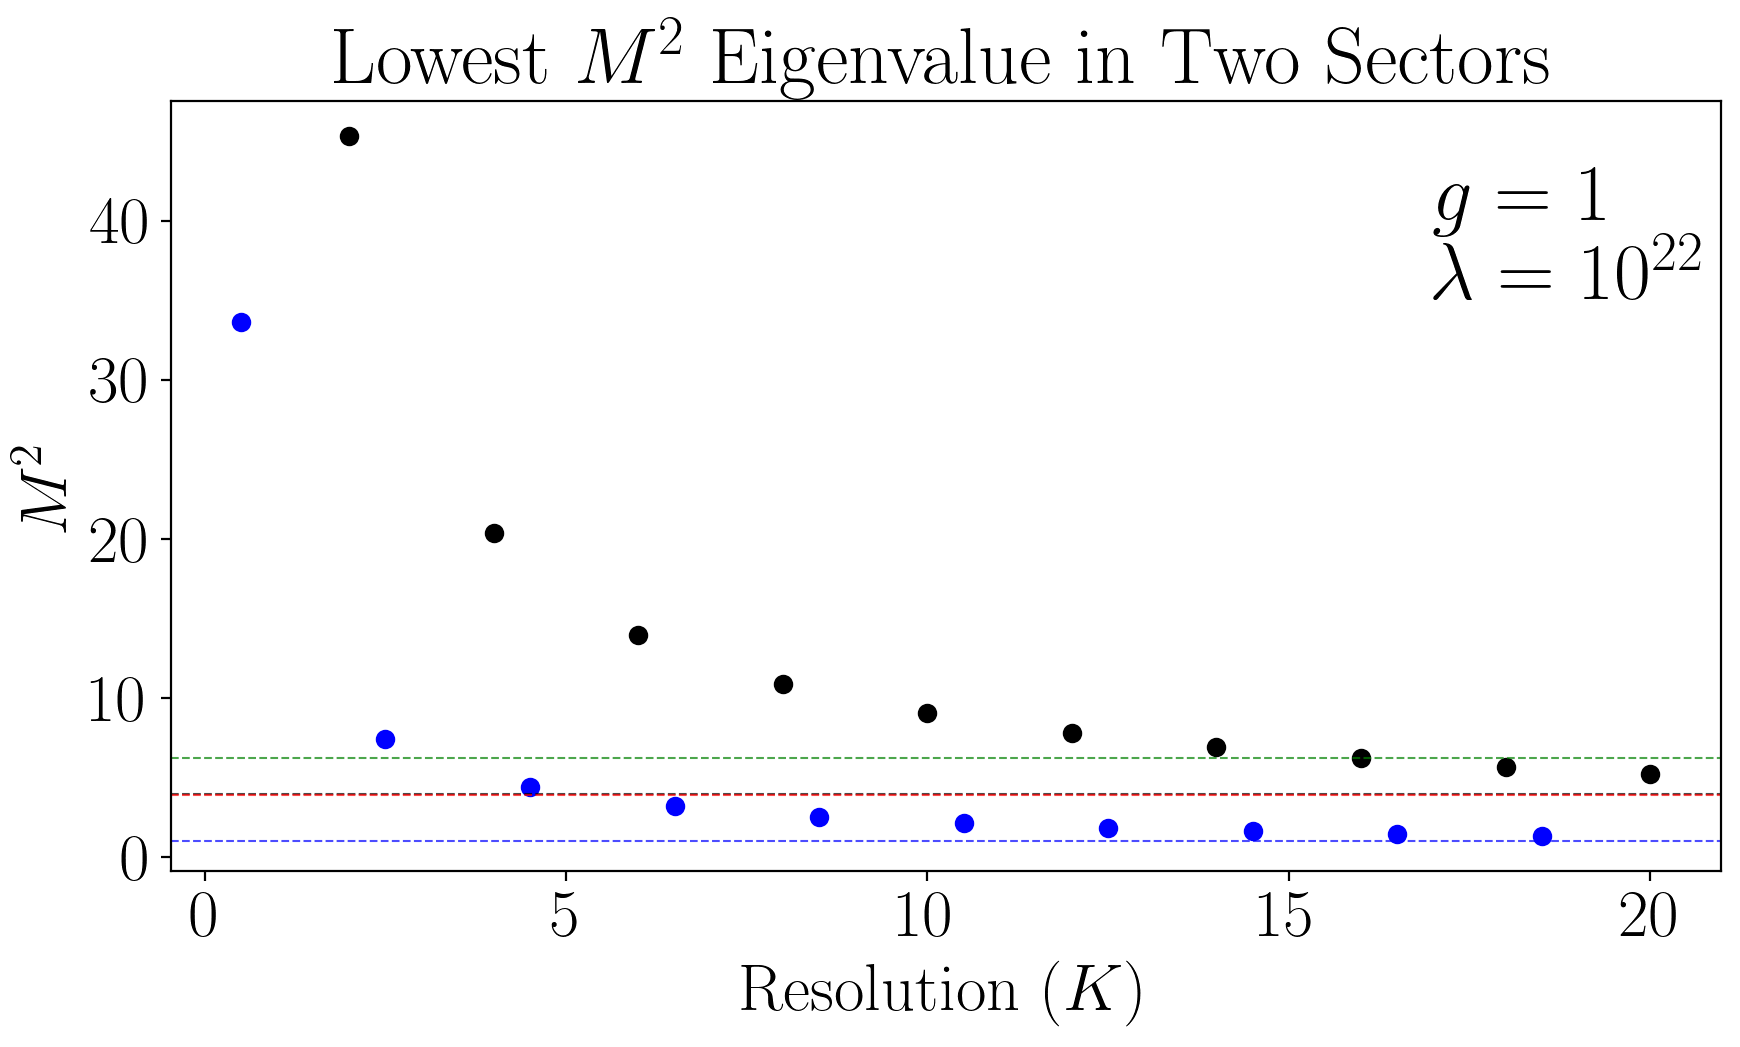

In [66]:
plt.figure(figsize=(10,5), dpi=200)

plt.plot(ff_ffb_resolutions, eigenvalues_ff_ffb_basis, 'ko')
plt.plot(f_fb_resolutions, eigenvalues_f_fb_basis, 'bo')

plt.axhline(y=mf**2, color='b', alpha = 0.7, linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf)**2, color='k', alpha = 0.7,linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf + mb)**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 0.75)
plt.axhline(y=min(nonrelativistic_yukawa(plot_3_g_1, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 0.75)

plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")
# plt.title(f'$g = {plot_3_g_1}$')
plt.title(r"Lowest $M^2$ Eigenvalue in Two Sectors")
plt.text(17, 40, f'$g = {plot_3_g_2}$', fontsize=29)
# plt.text(17, 7, f'$t = {1/(plot_3_t**2)}$', fontsize=29)
plt.text(17, 35, r'$\lambda = 10^{22}$', fontsize=29)



$g = 3$

In [67]:
max_K = 20

plot_3_g_2 = 3

eigenvalues_f_fb_basis = []
eigenvalues_ff_ffb_basis = []

f_fb_resolutions = np.arange(1/2, max_K, 2)
ff_ffb_resolutions = np.arange(2, max_K + 1, 2)

for res in f_fb_resolutions:

    f_fb_basis = (
        get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=plot_3_t, treg=0, g=plot_3_g_2, mf=mf, mb=mb, verbose=False
        )

    tmp_mat = generate_matrix_hermitian(hamiltonian, f_fb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_f_fb_basis.append(min(vals))

for res in ff_ffb_resolutions:

    ff_ffb_basis = (
        get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=plot_3_t, treg=0, g=plot_3_g_2, mf=mf, mb=mb, verbose=False
        )
    
    tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    eigenvalues_ff_ffb_basis.append(min(vals))

Text(17, 250, '$\\lambda = 10^{22}$')

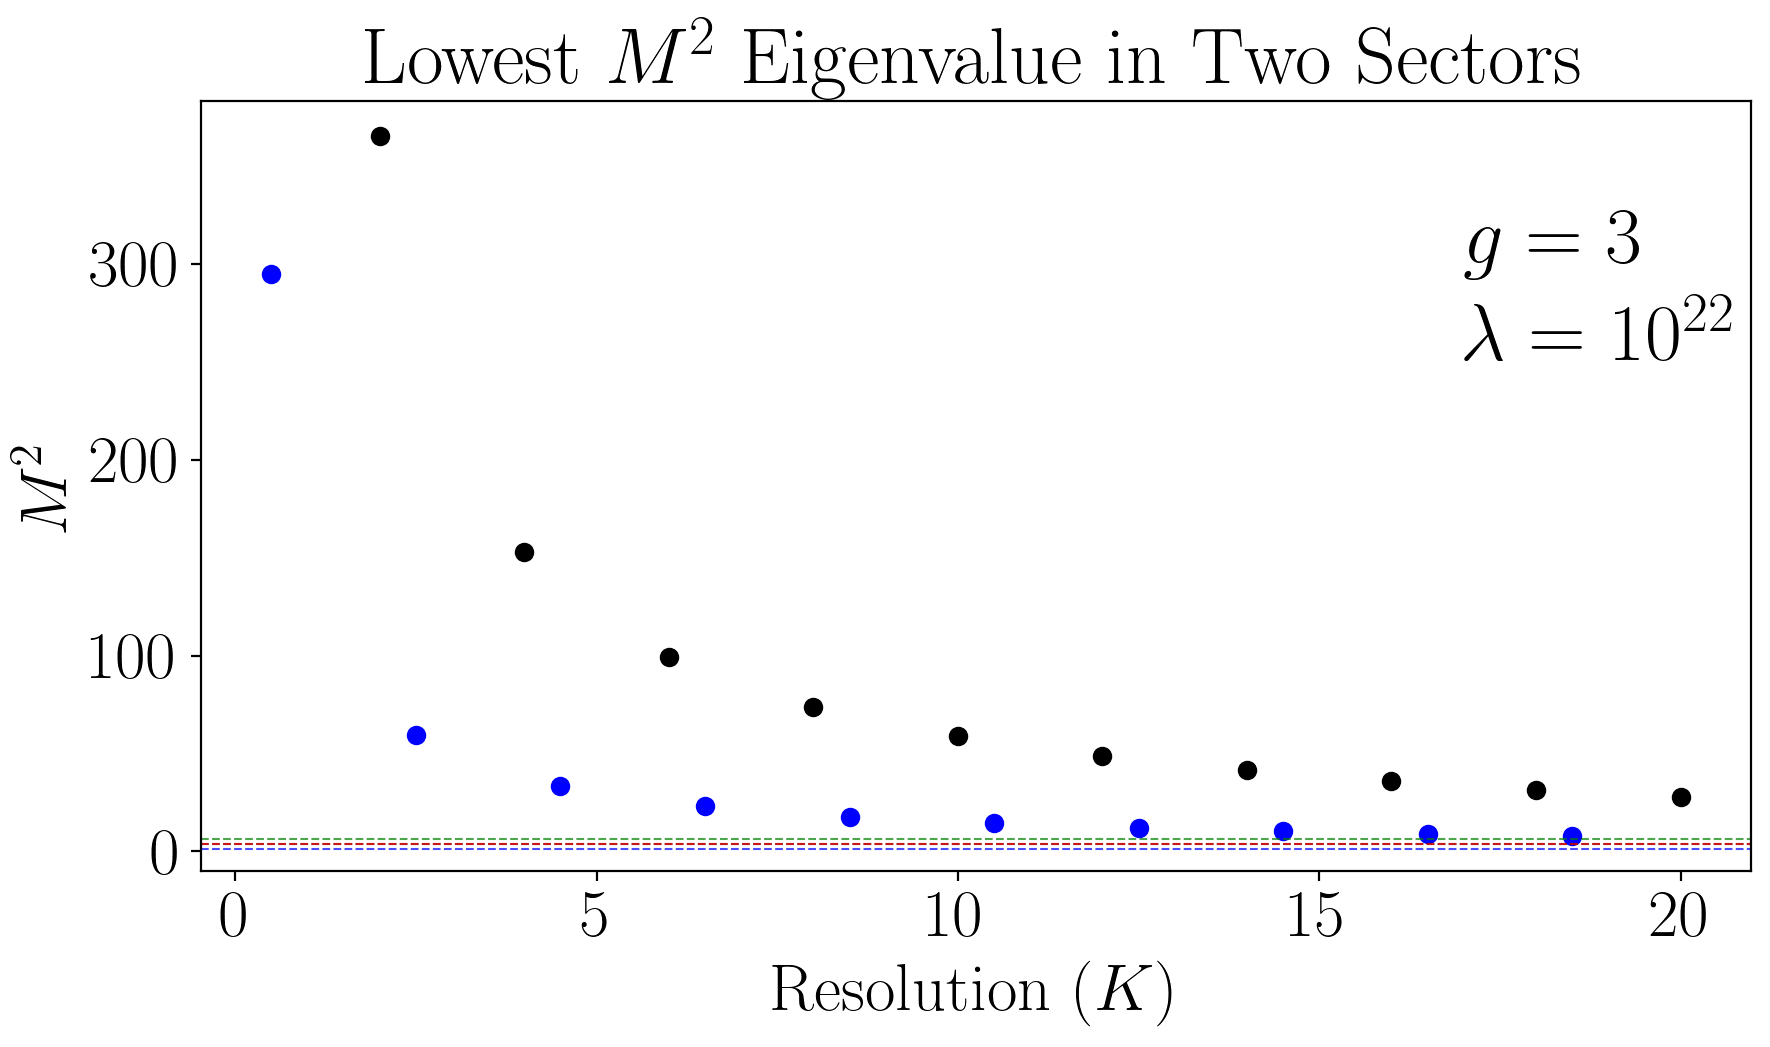

In [69]:
plt.figure(figsize=(10,5), dpi=200)

plt.plot(ff_ffb_resolutions, eigenvalues_ff_ffb_basis, 'ko')
plt.plot(f_fb_resolutions, eigenvalues_f_fb_basis, 'bo')

plt.axhline(y=mf**2, color='b', alpha = 0.7, linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf)**2, color='k', alpha = 0.7,linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf + mb)**2, color='green', alpha = 0.7, linestyle = '--', linewidth = 0.75)
plt.axhline(y=min(nonrelativistic_yukawa(plot_3_g_1, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', alpha = 0.7,linestyle = '--', linewidth = 0.75)

plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")
# plt.title(f'$g = {plot_3_g_1}$')
plt.title(r"Lowest $M^2$ Eigenvalue in Two Sectors")
plt.text(17, 300, f'$g = {plot_3_g_2}$', fontsize=29)
# plt.text(17, 7, f'$t = {1/(plot_3_t**2)}$', fontsize=29)
plt.text(17, 250, r'$\lambda = 10^{22}$', fontsize=29)



### `Plot #5`: Structure Function of $\{|ff\rangle, |ffb\rangle \}$ at $g = 1$

In [236]:
plot_4_res = 30

plot_4_g = 1
plot_4_t = 1e-12

ff_ffb_resolutions = np.arange(2, max_K + 1, 2)


ff_ffb_basis = (
    get_sector_basis(resolution = plot_4_res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
    + get_sector_basis(resolution = plot_4_res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
)  

hamiltonian = renormalized_yukawa_hamiltonian(
        res=plot_4_res, t=plot_4_t, treg=0, g=plot_4_g, mf=mf, mb=mb, verbose=False
    )

tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
vals, vecs = np.linalg.eigh(tmp_mat)

In [237]:
eigenstate = 0

psi = numpy_to_fock(vecs[:, eigenstate], ff_ffb_basis)

fermion_pdf = pdf(plot_4_res, psi, 'fermion')
boson_pdf = pdf(plot_4_res, psi, 'boson')


In [238]:
x_fermion = np.array([k/plot_4_res for k in np.arange(1/2, plot_4_res, 1)])
x_boson = np.array([k/plot_4_res for k in np.arange(1, plot_4_res + 1, 1)])

In [176]:
def pdf_fit(x, a, b, c):
    return a * np.exp(-(x - b)**2/c) 
    # return a / (1 + ((x - b) / c) ** 2)

In [177]:
fermion_fit_params = curve_fit(pdf_fit, x_fermion,  np.real(fermion_pdf), p0 = [0.6, 0.5, 0.01])
boson_fit_params = curve_fit(pdf_fit, x_boson, np.real(boson_pdf))

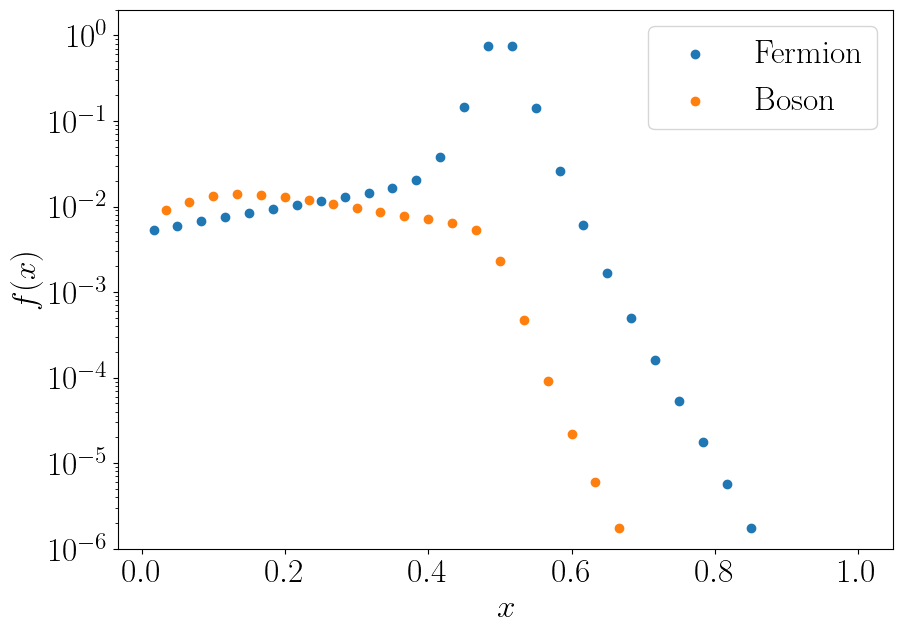

In [243]:
xnew = np.arange(0, 1, 0.001)

plt.figure(figsize = (10, 7), dpi = 100)

plt.scatter(x_fermion, np.real(fermion_pdf), label = f'Fermion')
# plt.plot(xnew, pdf_fit(xnew, *fermion_fit_params[0]), alpha = 0.5)

plt.scatter(x_boson, np.real(boson_pdf), label = f'Boson')
# plt.plot(xnew, pdf_fit(xnew, *boson_fit_params[0]), alpha = 0.5)
plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$f(x)$')
plt.ylim(1e-6, 2)
plt.yscale('log')
# plt.title(f"$ff$ bound state Structure Function")

### `Plot #5`: $m^2$ vs. $g$ extrapolation at $K_{max} = 20$, $t = 1e-12$

In [281]:
mf = 1
mb = 0.5
t = 1e-12

def l(x, a, b, c):
    return a + b/x + c/(x**2)



f_fb_basis = np.arange(1/2, 20, 2)

ms = []
ms_uncertainty=[]
gs = [0, 0.1, 0.25, 0.3, 0.5, 0.75, 1]
for g in gs:
    for res in f_fb_basis:
        eigenvalues_f_fb_basis = []
        basis = (
            get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
            + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
        )   
        
        hamiltonian = renormalized_yukawa_hamiltonian(
                res=res, t=t, treg=0, g=g, mf=mf, mb=mb, verbose=False
            )
        tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
        vals = np.linalg.eigvalsh(tmp_mat)
        eigenvalues_f_fb_basis.append(min(vals))
    params = curve_fit(l, f_fb_basis, eigenvalues_f_fb_basis)

    ms.append(params[0][0])
    ms_uncertainty.append(np.sqrt(np.diag(params[1]))[0])

Text(0, 1.35, 'K = 30')

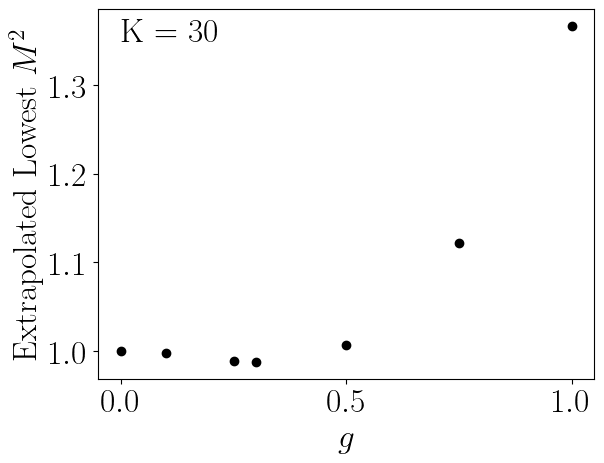

In [284]:
plt.plot(gs, ms, 'ko')
plt.ylabel(f"Extrapolated Lowest $M^2$")
plt.xlabel(f"$g$")
plt.text(0, 1.35, f'K = 30')

### `Plot #7`: $M^2$ Extrapolated vs. $t$ in $\{|f\rangle, |fb\rangle \}$ and $\{|ff\rangle, |ffb\rangle \}$ at $g = 0.3$

In [326]:
plot_7_g = 0.3
ts = [1e-14, 1e-11, 1e-8, 1e-5, 1e-2, 1, 10]

plot_7_max_K = 20

half_integer_Ks = np.arange(1/2, plot_7_max_K, 1)
integer_Ks = np.arange(2, plot_7_max_K, 1)


f_fb_fits = []
ff_ffb_fits = []

for t in ts:
    eigenvalues_f_fb_basis = []
    eigenvalues_ff_ffb_basis = []

    #f + fb
    
    for res in half_integer_Ks:
        f_fb_basis = (
            get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
            + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
        )  
        hamiltonian = renormalized_yukawa_hamiltonian(res = res, t = t, treg = 0, g = plot_7_g, mf = mf, mb = mb)
        tmp_mat = generate_matrix_hermitian(hamiltonian, f_fb_basis)
        vals = np.linalg.eigvalsh(tmp_mat)
        eigenvalues_f_fb_basis.append(min(vals))

    params = curve_fit(m2_fit, half_integer_Ks, eigenvalues_f_fb_basis)
    f_fb_fits.append(m2_fit(np.inf, *params[0]))

        

    #ff + ffb
    
    for res in integer_Ks:
        ff_ffb_basis = (
            get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
            + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
        )  
        hamiltonian = renormalized_yukawa_hamiltonian(res = res, t = t, treg = 0, g = plot_7_g, mf = mf, mb = mb)
        tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
        vals = np.linalg.eigvalsh(tmp_mat)
        eigenvalues_ff_ffb_basis.append(min(vals))
    params = curve_fit(m2_fit, integer_Ks, eigenvalues_ff_ffb_basis)
    ff_ffb_fits.append(m2_fit(np.inf, *params[0]))



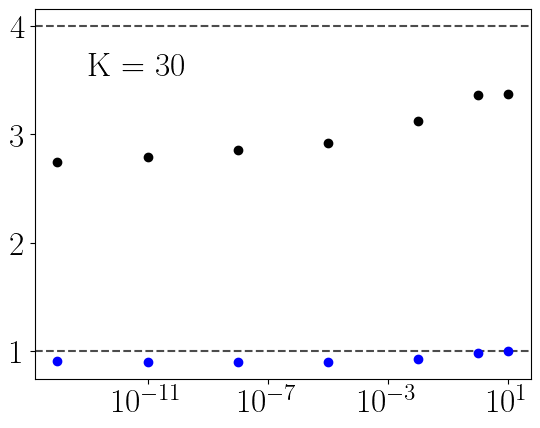

In [332]:
plt.axhline(y = mf**2, color = 'k', linestyle = '--', alpha = 0.7)
plt.axhline(y = 4*mf**2, color = 'k', linestyle = '--', alpha = 0.7)
plt.plot(ts, f_fb_fits, 'bo')
plt.plot(ts, ff_ffb_fits, 'ko')
plt.text(1e-13, 3.55, f'K = 30')
plt.xscale('log')

Without extrapolation at $K = 18$

In [328]:
k30_fits_f_fb = []
k30_fits_ff_ffb = []
K = 11

for t in ts:
    eigenvalues_f_fb_basis = []
    eigenvalues_ff_ffb_basis = []

    #f + fb
    

    f_fb_basis = (
        get_sector_basis(resolution = K + 1/2, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = K + 1/2, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
    )  
    hamiltonian = renormalized_yukawa_hamiltonian(res = 15 + 1/2, t = t, treg = 0, g = plot_7_g, mf = mf, mb = mb)
    tmp_mat = generate_matrix_hermitian(hamiltonian, f_fb_basis)
    vals = np.linalg.eigvalsh(tmp_mat)
    k30_fits_f_fb.append(min(vals))


        

    #ff + ffb
    
    ff_ffb_basis = (
        get_sector_basis(resolution = K + 1, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = K + 1, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
    )  
    hamiltonian = renormalized_yukawa_hamiltonian(res = 16, t = t, treg = 0, g = plot_7_g, mf = mf, mb = mb)
    tmp_mat = generate_matrix_hermitian(hamiltonian, ff_ffb_basis)
    vals = np.linalg.eigvalsh(tmp_mat)
    eigenvalues_ff_ffb_basis.append(min(vals))
    k30_fits_ff_ffb.append(min(vals))

    

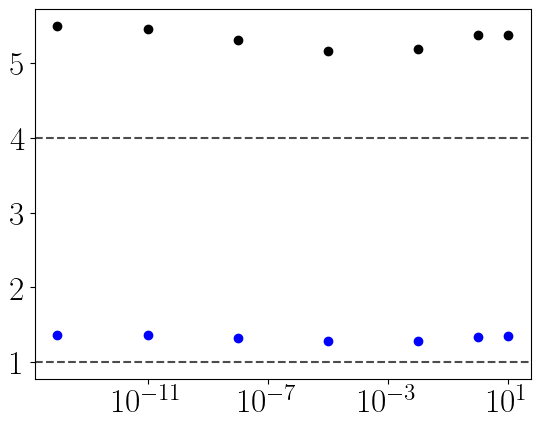

In [329]:
plt.axhline(y = mf**2, color = 'k', linestyle = '--', alpha = 0.7)
plt.axhline(y = 4*mf**2, color = 'k', linestyle = '--', alpha = 0.7)
plt.plot(ts, k30_fits_f_fb, 'bo')
plt.plot(ts, k30_fits_ff_ffb, 'ko')
plt.xscale('log')